#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
# !pip install -q tqdm
# !pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import datetime

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import utils
from torch.functional import F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

2024-11-23 23:42:17.925637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732394537.942763 3686143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732394537.948016 3686143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 23:42:17.964883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name, transform=None):
        self.name = name
        self.is_loaded = False
        self.transform = transform
        # check if dataset is already downloaded
        if not Path(f'{name}.npz').exists():
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
            print(f'Downloading dataset {self.name} from {url}.')
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
        
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]
    
    #LBL15
    def __len__(self):
        return self.n_files
    
    def __getitem__(self, idx):
        if self.is_loaded:
            img = self.images[idx]
            label = self.labels[idx]
            img = Image.fromarray(img)
            if self.transform:
                img_tensor = self.transform(img)
            else:
                img_tensor = transforms.ToTensor()(img)
            # img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0 
            label_tensor = torch.tensor(label, dtype=torch.long)
            return img_tensor, label_tensor

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 8.
Label code corresponds to TUM class.


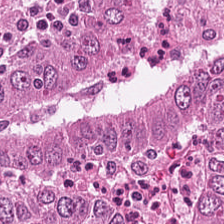

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        # self.classifier = nn.Linear(256, num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [9]:
from torchvision.models import resnet50


class FineTunedResNet(nn.Module):
    def __init__(self, num_classes=9):
        super(FineTunedResNet, self).__init__()
        self.resnet = resnet50(pretrained=True)
        # self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.resnet(x)



In [ ]:
class Model:
    def __init__(self, 
                 model: nn.Module, 
                 criterion: nn.Module = nn.CrossEntropyLoss(), 
                 optimizer_fn: optim.Optimizer = optim.Adam, 
                 optimizer_params: dict = {"lr": 0.001}, 
                 scheduler_type: str = "constant", 
                 scheduler_params: dict = None, 
                 log_dir: str = "runs/model",
                ):
        """
        Initialize the Model class with custom model, criterion, optimizer, and scheduler.

        :param model: PyTorch model instance (e.g., SimpleCNN) or pre-trained model #LBL7&
        :param criterion: Loss function (default: CrossEntropyLoss).
        :param optimizer_fn: Optimizer class (e.g., optim.Adam).
        :param optimizer_params: Parameters for the optimizer (default: {"lr": 0.001}).
        :param scheduler_type: Type of learning rate scheduler ("constant", "step", "reduce_on_plateau").
        :param scheduler_params: Parameters for the scheduler (e.g., step_size, factor).
        :param log_dir: Directory for TensorBoard logs.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device {self.device}")
        
        self.model = model.to(self.device)
        #LBL9 
        self.criterion = criterion
        #LBL8
        self.optimizer = optimizer_fn(self.model.parameters(), **optimizer_params)
        self.best_val_loss = float('inf')
        self.best_accuracy = 0
        self.conf_matrix = None

        self.acs_train = []
        self.loss_train = []

        self.acs_val = []
        self.loss_val = []

        # Configure scheduler based on type
        #LBL10 
        if scheduler_type == "step":
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, **scheduler_params)
        elif scheduler_type == "reduce_on_plateau":
            self.scheduler = ReduceLROnPlateau(self.optimizer, **scheduler_params)
        else:
            self.scheduler = None  # Constant learning rate

        self.writer = SummaryWriter(log_dir)
        print(f"Model initialized. Device: {self.device}")
        print(next(self.model.parameters()).device)

    def train(self, train_loader, val_loader=None, epochs=10, early_stopping_patience=10, save_path="best_model.pth"):
        """
        Train the model with optional validation and learning rate scheduling.

        :param train_loader: DataLoader for training data.
        :param val_loader: DataLoader for validation data (optional).
        :param epochs: Number of epochs to train.
        :param early_stopping_patience: Patience for early stopping.
        :param save_path: Path to save the best model.
        """
        best_val_loss = float('inf')
        no_improvement_epochs = 0

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100. * correct / total
            print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
            #LBL3
            self.writer.add_scalar("Training Loss", train_loss, epoch + 1)
            self.writer.add_scalar("Training Accuracy", train_accuracy, epoch + 1)
            self.acs_train.append(train_accuracy)
            self.loss_train.append(train_loss)


            # Validation
            #LBL1
            if val_loader:
                val_loss, val_accuracy = self.evaluate(val_loader)
                print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
                self.writer.add_scalar("Validation Loss", val_loss, epoch + 1)
                self.writer.add_scalar("Validation Accuracy", val_accuracy, epoch + 1)
                self.acs_val.append(val_accuracy)
                self.loss_val.append(val_loss)

                # Early Stopping LBL11
                if val_accuracy > self.best_accuracy:
                    self.best_accuracy = val_accuracy
                    no_improvement_epochs = 0
                    self.best_val_loss = best_val_loss
                    #LBL2
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Saved new best model: {save_path}")
                else:
                    no_improvement_epochs += 1
                    if no_improvement_epochs >= early_stopping_patience:
                        print("Early stopping triggered.")
                        break
            self.writer.flush()
            # Adjust learning rate if scheduler is used
            if self.scheduler:
                if isinstance(self.scheduler, ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
    #LBL4
    def evaluate(self, data_loader, plot_conf_matrix=False):
        """
        Evaluate the model on a dataset.

        :param data_loader: DataLoader for evaluation data.
        :return: Average loss and accuracy.
        """
        self.model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(data_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100. * correct / total
        avg_loss = running_loss / len(data_loader)
        if plot_conf_matrix:
            self.conf_matrix = self._compute_confusion_matrix(all_labels, all_preds)
            sensitivity, specificity = self.compute_sensitivity_specificity(self.conf_matrix)
            self.print_sensitivity_specificity(sensitivity, specificity)

        return avg_loss, accuracy
    
    #LBL14
    def _compute_confusion_matrix(self, true_labels, predicted_labels):
        """
        Compute confusion matrix and plot it.
        """
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.arange(len(conf_matrix)))
        disp.plot(cmap=plt.cm.Blues, values_format="d")
        plt.title("Confusion Matrix")
        plt.show()
        return conf_matrix

    def plot_metrics(self, conf_matrix):
        """
        Plot confusion matrix as a heatmap.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=TISSUE_CLASSES, yticklabels=TISSUE_CLASSES)
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.title("Confusion Matrix")
        plt.show()

    #LBL13
    def plot_learning_curves(self):
        """
        Plot learning curves for training and validation.
        """
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        ax[0].plot(self.acs_train, label="Training Accuracy", color="blue")
        ax[0].plot(self.acs_val, label="Validation Accuracy", color="red")
        ax[0].set_title("Accuracy")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()
        ax[0].grid(True)

        ax[1].plot(self.loss_train, label="Training Loss", color="blue")
        ax[1].plot(self.loss_val, label="Validation Loss", color="red")
        ax[1].set_title("Loss")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        ax[1].grid(True)

        plt.show()

    #LBL5
    def save(self, path):
        """
        Save the model state.

        :param path: Path to save the model.
        """
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")
            
    #LBL6 
    def load(self, path='res', val_loader=None, load_from_cloud=True, file_id="121I9VB7bGrKRsRsW3XuLU0chLdOqMUsP"):
        """
        Load the model state.

        :param path: Path to load the model from.
        :param val_loader: DataLoader for validation data (optional).
        :param load_from_cloud: Load best model from cloud.
        """
        if load_from_cloud:
            url = f"https://drive.google.com/uc?id={file_id}"
            print(f"Loading model from {url}")
            gdown.download(url, path, quiet=False)
        print(f"Loading model from {path}")
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)
        # test it on validation dataset so we dont replace model with worse one
        if val_loader:
            val_loss, val_accuracy = self.evaluate(val_loader)
            print(f"Model loaded. Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            self.best_val_loss = val_loss

    def test_on_image(self, img: np.ndarray):
        """
        Test the model on a single image.

        :param img: Image as a NumPy array.
        :return: Predicted label.
        """
        self.model.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
            img_tensor = img_tensor.unsqueeze(0).to(self.device)
            outputs = self.model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            return predicted.item()

    def test_on_dataset(self, dataset: Dataset, limit=None, batch_size=64, plot_conf_matrix=False):
        self.model.eval()
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        with torch.no_grad():
            for inputs, _ in tqdm(data_loader, desc="Testing"):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
                if len(predictions) >= n:
                    break   

        predictions = predictions[:n]   
        if plot_conf_matrix:
            self.conf_matrix = self._compute_confusion_matrix(dataset.labels[:n], predictions)
            sensitivity, specificity = self.compute_sensitivity_specificity(self.conf_matrix)
            self.print_sensitivity_specificity(sensitivity, specificity)
        return predictions
    
    def compute_sensitivity_specificity(self, conf_matrix):
        """
        Compute sensitivity and specificity from the confusion matrix.

        :param conf_matrix: Confusion matrix (numpy array).
        :return: Tuple of (sensitivity_list, specificity_list)
        """
        num_classes = conf_matrix.shape[0]
        sensitivity = []
        specificity = []

        for i in range(num_classes):
            TP = conf_matrix[i, i]
            FN = conf_matrix[i, :].sum() - TP
            FP = conf_matrix[:, i].sum() - TP
            TN = conf_matrix.sum() - (TP + FN + FP)

            sens = TP / (TP + FN) if (TP + FN) > 0 else 0
            spec = TN / (TN + FP) if (TN + FP) > 0 else 0

            sensitivity.append(sens)
            specificity.append(spec)

        return sensitivity, specificity

    def print_sensitivity_specificity(self, sensitivity, specificity):
            """
            Print sensitivity and specificity for each class.

            :param sensitivity: List of sensitivity values per class.
            :param specificity: List of specificity values per class.
            """
            print("\nSensitivity and Specificity per class:")
            for idx, class_name in enumerate(TISSUE_CLASSES):
                print(f"Class '{class_name}': Sensitivity: {sensitivity[idx]:.4f}, Specificity: {specificity[idx]:.4f}")



---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [11]:
tr_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3), # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.3), # Random vertical
    transforms.RandomApply([transforms.RandomRotation(45)], p=0.3), # Random rotation with probability
    transforms.ToTensor(),
])

val_transf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

d_train = Dataset('train', transform=tr_transf)
d_test = Dataset('test', transform=val_transf)

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [12]:
len_img=len(d_train)
len_train=int(0.8 * len_img)
len_val=len_img-len_train

targets = d_train.labels

train_indices, val_indices = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

train_ts = Subset(d_train, train_indices)
val_ts = Subset(d_train, val_indices)


print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 14400
validation dataset size: 3600


In [13]:
train_loader = DataLoader(train_ts, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ts, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

torch.Size([64, 3, 224, 224])
tensor(0.) tensor(1.)
tensor([7, 7, 4, 8, 5, 1, 5, 1, 2, 0, 0, 5, 3, 0, 2, 8, 2, 5, 5, 1, 6, 8, 6, 0,
        6, 1, 2, 0, 3, 3, 2, 8, 3, 6, 5, 5, 6, 2, 6, 4, 4, 2, 4, 8, 2, 8, 3, 8,
        6, 6, 4, 1, 0, 7, 6, 1, 4, 5, 8, 5, 8, 6, 3, 5])


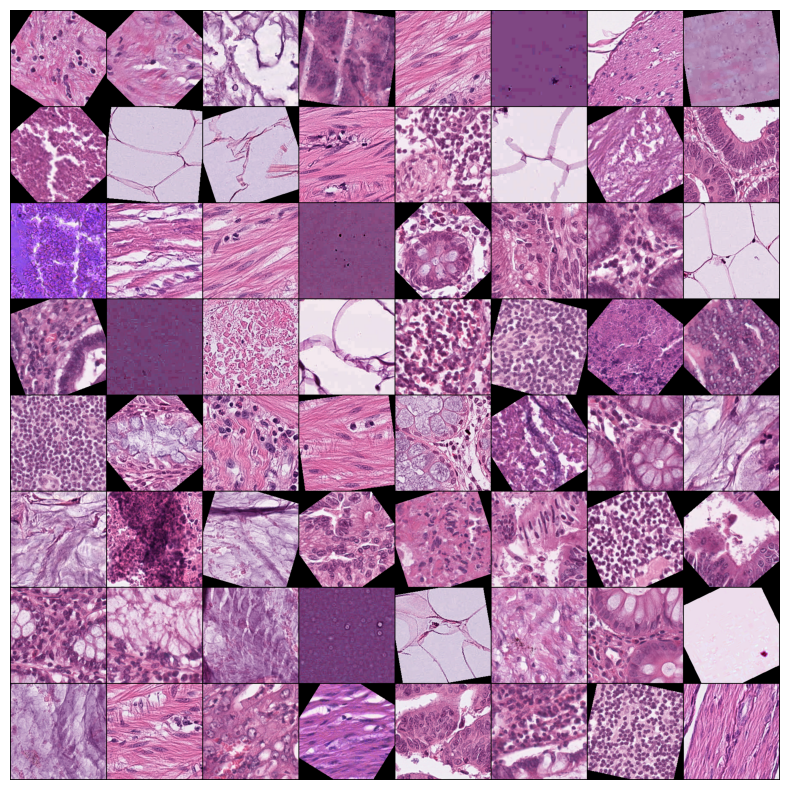

In [14]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(images.shape)
print(images.min(), images.max())  # Проверка диапазона значений
print(labels)

# Отображение изображений
img = utils.make_grid(images, nrow=8, padding=2)
np_img = img.cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [15]:
# model = Model(
#     model=SimpleCNN(num_classes=9),
#     optimizer_fn=optim.Adam,
#     optimizer_params={"lr": 0.001},
#     scheduler_type="step",
#     scheduler_params={"step_size": 5, "gamma": 0.1},
#     log_dir=f"runs/model_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# )

model = Model(
    model=FineTunedResNet(num_classes=9),
    optimizer_fn=optim.Adam,
    optimizer_params={"lr": 0.001},
    scheduler_type="step",
    scheduler_params={"step_size": 5, "gamma": 0.1},
    log_dir=f"runs/model_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
)



/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device cuda
Model initialized. Device: cuda
cuda:0


In [16]:

EVALUATE_ONLY = False
if not EVALUATE_ONLY:
    model.train(train_loader, val_loader, epochs=20)
    model.save("last_model.pth")
else:
    model.load("./res.pth", load_from_cloud=True)

Epoch 1/20: 100%|██████████| 225/225 [00:16<00:00, 13.65it/s]


Epoch [1/20] - Training Loss: 0.4426, Accuracy: 85.89%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.23it/s]


Validation Loss: 0.3785, Validation Accuracy: 88.67%
Saved new best model: best_model.pth


Epoch 2/20: 100%|██████████| 225/225 [00:15<00:00, 14.22it/s]


Epoch [2/20] - Training Loss: 0.2452, Accuracy: 92.67%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.16it/s]


Validation Loss: 1.2651, Validation Accuracy: 71.36%


Epoch 3/20: 100%|██████████| 225/225 [00:15<00:00, 14.24it/s]


Epoch [3/20] - Training Loss: 0.1906, Accuracy: 94.15%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.49it/s]


Validation Loss: 6.3459, Validation Accuracy: 45.36%


Epoch 4/20: 100%|██████████| 225/225 [00:15<00:00, 14.29it/s]


Epoch [4/20] - Training Loss: 0.1338, Accuracy: 95.86%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.17it/s]


Validation Loss: 0.1298, Validation Accuracy: 95.86%
Saved new best model: best_model.pth


Epoch 5/20: 100%|██████████| 225/225 [00:15<00:00, 14.23it/s]


Epoch [5/20] - Training Loss: 0.1279, Accuracy: 95.97%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.70it/s]


Validation Loss: 0.9454, Validation Accuracy: 74.31%


Epoch 6/20: 100%|██████████| 225/225 [00:15<00:00, 14.20it/s]


Epoch [6/20] - Training Loss: 0.0581, Accuracy: 98.12%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.90it/s]


Validation Loss: 0.0422, Validation Accuracy: 98.50%
Saved new best model: best_model.pth


Epoch 7/20: 100%|██████████| 225/225 [00:15<00:00, 14.19it/s]


Epoch [7/20] - Training Loss: 0.0507, Accuracy: 98.42%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.01it/s]


Validation Loss: 0.0406, Validation Accuracy: 98.75%
Saved new best model: best_model.pth


Epoch 8/20: 100%|██████████| 225/225 [00:15<00:00, 14.21it/s]


Epoch [8/20] - Training Loss: 0.0385, Accuracy: 98.81%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.61it/s]


Validation Loss: 0.0390, Validation Accuracy: 98.69%


Epoch 9/20: 100%|██████████| 225/225 [00:15<00:00, 14.16it/s]


Epoch [9/20] - Training Loss: 0.0369, Accuracy: 98.83%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.33it/s]


Validation Loss: 0.0373, Validation Accuracy: 98.83%
Saved new best model: best_model.pth


Epoch 10/20: 100%|██████████| 225/225 [00:15<00:00, 14.22it/s]


Epoch [10/20] - Training Loss: 0.0330, Accuracy: 98.92%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.73it/s]


Validation Loss: 0.0382, Validation Accuracy: 98.86%
Saved new best model: best_model.pth


Epoch 11/20: 100%|██████████| 225/225 [00:15<00:00, 14.26it/s]


Epoch [11/20] - Training Loss: 0.0336, Accuracy: 98.99%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.61it/s]


Validation Loss: 0.0342, Validation Accuracy: 99.06%
Saved new best model: best_model.pth


Epoch 12/20: 100%|██████████| 225/225 [00:15<00:00, 14.20it/s]


Epoch [12/20] - Training Loss: 0.0300, Accuracy: 99.01%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.71it/s]


Validation Loss: 0.0310, Validation Accuracy: 99.08%
Saved new best model: best_model.pth


Epoch 13/20: 100%|██████████| 225/225 [00:15<00:00, 14.20it/s]


Epoch [13/20] - Training Loss: 0.0303, Accuracy: 99.13%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.98it/s]


Validation Loss: 0.0313, Validation Accuracy: 98.89%


Epoch 14/20: 100%|██████████| 225/225 [00:15<00:00, 14.20it/s]


Epoch [14/20] - Training Loss: 0.0291, Accuracy: 99.07%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.13it/s]


Validation Loss: 0.0272, Validation Accuracy: 99.06%


Epoch 15/20: 100%|██████████| 225/225 [00:15<00:00, 14.21it/s]


Epoch [15/20] - Training Loss: 0.0262, Accuracy: 99.24%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.19it/s]


Validation Loss: 0.0317, Validation Accuracy: 99.11%
Saved new best model: best_model.pth


Epoch 16/20: 100%|██████████| 225/225 [00:15<00:00, 14.28it/s]


Epoch [16/20] - Training Loss: 0.0253, Accuracy: 99.28%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.16it/s]


Validation Loss: 0.0285, Validation Accuracy: 99.25%
Saved new best model: best_model.pth


Epoch 17/20: 100%|██████████| 225/225 [00:15<00:00, 14.26it/s]


Epoch [17/20] - Training Loss: 0.0273, Accuracy: 99.12%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.63it/s]


Validation Loss: 0.0316, Validation Accuracy: 99.17%


Epoch 18/20: 100%|██████████| 225/225 [00:15<00:00, 14.26it/s]


Epoch [18/20] - Training Loss: 0.0269, Accuracy: 99.25%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.42it/s]


Validation Loss: 0.0298, Validation Accuracy: 99.03%


Epoch 19/20: 100%|██████████| 225/225 [00:15<00:00, 14.22it/s]


Epoch [19/20] - Training Loss: 0.0234, Accuracy: 99.32%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.12it/s]


Validation Loss: 0.0296, Validation Accuracy: 99.19%


Epoch 20/20: 100%|██████████| 225/225 [00:15<00:00, 14.19it/s]


Epoch [20/20] - Training Loss: 0.0255, Accuracy: 99.27%


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 35.72it/s]


Validation Loss: 0.0282, Validation Accuracy: 99.06%
Model saved to last_model.pth


/tmp/ipykernel_3686143/3232354897.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


Loading model from best_model.pth


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.23it/s]


Model loaded. Validation Loss: 0.0294, Validation Accuracy: 99.06%


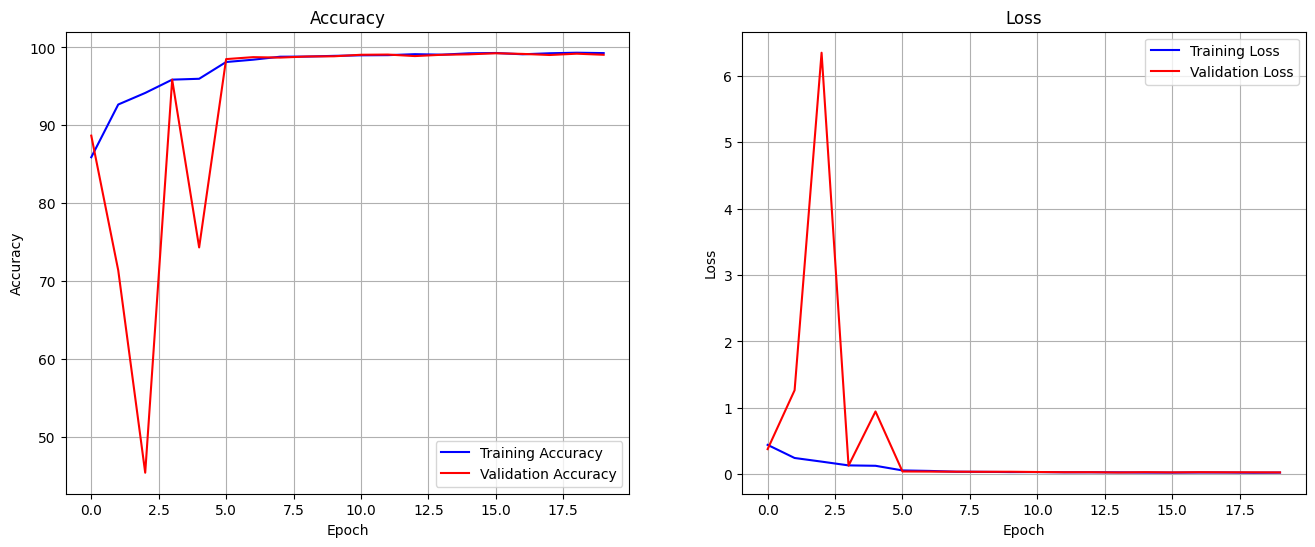

In [17]:
model.load('best_model.pth', val_loader=val_loader, load_from_cloud=False)
model.plot_learning_curves()

Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.07it/s]


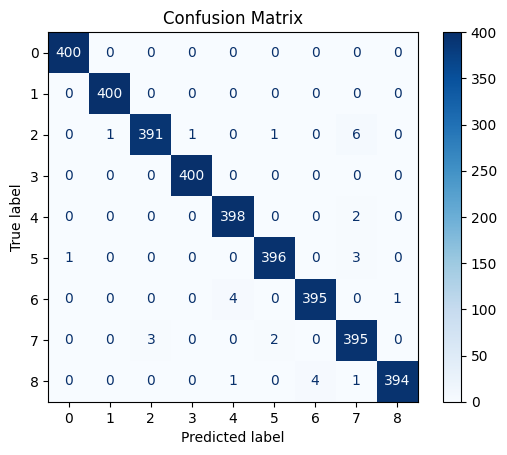


Sensitivity and Specificity per class:
Class 'ADI': Sensitivity: 1.0000, Specificity: 0.9997
Class 'BACK': Sensitivity: 1.0000, Specificity: 0.9997
Class 'DEB': Sensitivity: 0.9775, Specificity: 0.9991
Class 'LYM': Sensitivity: 1.0000, Specificity: 0.9997
Class 'MUC': Sensitivity: 0.9950, Specificity: 0.9984
Class 'MUS': Sensitivity: 0.9900, Specificity: 0.9991
Class 'NORM': Sensitivity: 0.9875, Specificity: 0.9988
Class 'STR': Sensitivity: 0.9875, Specificity: 0.9962
Class 'TUM': Sensitivity: 0.9850, Specificity: 0.9997


(0.028879902600269895, 99.13888888888889)

In [18]:
model.evaluate(val_loader, plot_conf_matrix=True)

Пример тестирования модели на части набора данных:

In [19]:
# model.load('res.pth', val_loader=val_loader, load_from_cloud=False)

In [20]:
predictions = model.test_on_dataset(d_test, limit=0.1, plot_conf_matrix=False)
Metrics.print_all(d_test.labels[:len(predictions)], predictions, '10% of test')

Testing:  10%|▉         | 7/71 [00:00<00:05, 12.54it/s]


metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [21]:
# test on 1 image 
img, lbl = d_test.random_image_with_label()
pred = model.test_on_image(img)
print(f'predicted class: {TISSUE_CLASSES[pred]}, true class: {TISSUE_CLASSES[lbl]}')


predicted class: TUM, true class: TUM


Пример тестирования модели на полном наборе данных:

Testing:  99%|█████████▊| 70/71 [00:02<00:00, 27.69it/s]


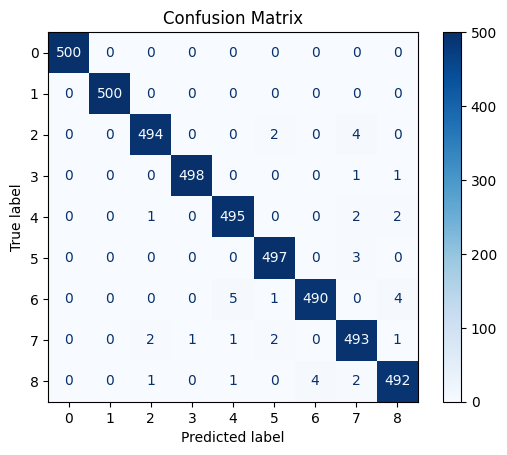


Sensitivity and Specificity per class:
Class 'ADI': Sensitivity: 1.0000, Specificity: 1.0000
Class 'BACK': Sensitivity: 1.0000, Specificity: 1.0000
Class 'DEB': Sensitivity: 0.9880, Specificity: 0.9990
Class 'LYM': Sensitivity: 0.9960, Specificity: 0.9998
Class 'MUC': Sensitivity: 0.9900, Specificity: 0.9982
Class 'MUS': Sensitivity: 0.9940, Specificity: 0.9988
Class 'NORM': Sensitivity: 0.9800, Specificity: 0.9990
Class 'STR': Sensitivity: 0.9860, Specificity: 0.9970
Class 'TUM': Sensitivity: 0.9840, Specificity: 0.9980
metrics for test:
	 accuracy 0.9909:
	 balanced accuracy 0.9909:


In [22]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test, plot_conf_matrix=True)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [24]:

model.load('best_model.pth', val_loader=val_loader, load_from_cloud=False)
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/tmp/ipykernel_3686143/3232354897.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


Loading model from best_model.pth


Evaluating: 100%|██████████| 57/57 [00:01<00:00, 36.33it/s]


Model loaded. Validation Loss: 0.0281, Validation Accuracy: 98.97%
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Testing:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s]

metrics for test-tiny:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:
